## Анализ и сравнение различных подходов

Здесь проводится оценка полученных результатов. Более подробно каждая модель описана в соответствующем ноутбуке.

### Численные результаты и графики

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
import seaborn as sns
sns.set_theme()
import json
import os

Объединим результаты обучения трех моделей в один DataFrame для удобства работы. Далее по тексту под номером модели понимается нумерация, приведенная ниже:
1. [DistilBERT Encoder](https://colab.research.google.com/drive/1sT5tPaRasXq2M55whxb1hPnz-adBan6e?usp=sharing) — трансформер с предобученным DistilBERT в качестве энкодера.
2. [Improved LSTM](https://colab.research.google.com/drive/1ZI7N4Tm2UIR1-oqTI3OR5xV53vTS3D8B?usp=sharing) — базовая LSTM с некоторыми улучшениями.
3. [CNN-Transformer](https://colab.research.google.com/drive/1FSQUn3Iy10Ft05WUSxdPV6rAJ7odTbCe?usp=sharing) — CNN-энкодер с Transformer-декодером.

Колонки:
- num_params — кол-во обучаемых параметров.
- train_time — среднее время обучения одной эпохи в минутах. Так как DistilBERT обучался в два этапа со средним временем 20 и 30 минут, в таблице указано среднее арифметическое этих значений.
- eval_time — время инференса на тестовых данных (7500 последовательностей) в минутах, без учета вычисления BLEU score
- *_loss — итоговый лосс на соответствующей части данных.
- *_ppl — итоговая Perplexity на соответствующей части данных.
- bleu — BLEU score на тестовых данных (от 0 до 100)

В достоверности предоставленных результатов можно убедиться, просмотрев соответствующие ноутбуки.

In [ ]:
results = pd.DataFrame(
    index=["DistilBERT Encoder", "Improved LSTM", "CNN-Transformer"],
    data = {
        "num_params": [98_158_393, 25_032_761, 59_725_688],
        "train_time": [25, 6.5, 9],
        "eval_time": [3.13, 0.35, 0.2],
        "train_loss": [0.719, 2.040, 1.660],
        "val_loss": [1.481, 4.043, 2.065],
        "test_loss": [1.495, 3.983, 2.069],
        "train_ppl": [2.051, 7.690, 5.261],
        "val_ppl": [4.399, 56.993, 7.886],
        "test_ppl": [4.460, 53.702, 7.918],
        "bleu": [32.12, 27.46, 27.88]
    }
)

results.head()

,num_params,train_time,eval_time,train_loss,val_loss,test_loss,train_ppl,val_ppl,test_ppl,bleu
DistilBERT Encoder,98158393,25.0,3.13,0.719,1.481,1.495,2.051,4.399,4.460,32.12
Improved LSTM,25032761,6.5,0.35,2.040,4.043,3.983,7.690,56.993,53.702,27.46
CNN-Transformer,59725688,9.0,0.20,1.660,2.065,2.069,5.261,7.886,7.918,27.88


Самой большой моделью является первая, что соответствующим образом сказывается на времени обучения и инференса. Затем в порядке убывания идут третья модель и вторая. Примечательно, что несмотря на превосходящее более чем в 2 раза число параметров модели CNN-Transformer, по сравнению с LSTM, время инференса модели со свертками вдвое меньше, чем у реккурентной сети. Это объясняется тем, что self-attention и свертки эффективно распараллеливаются.

Все лоссы, PPL и BLEU находятся в обратной относительно размеров модели зависимости. Однако стоит заметить, что несмотря на значительно отстающие показатели лосса и PPL у модели LSTM, BLEU отстает от CNN-Transformer лишь на 0.42, что говорит о слабой связи уменьшения лосса и увеличения BLEU score. 

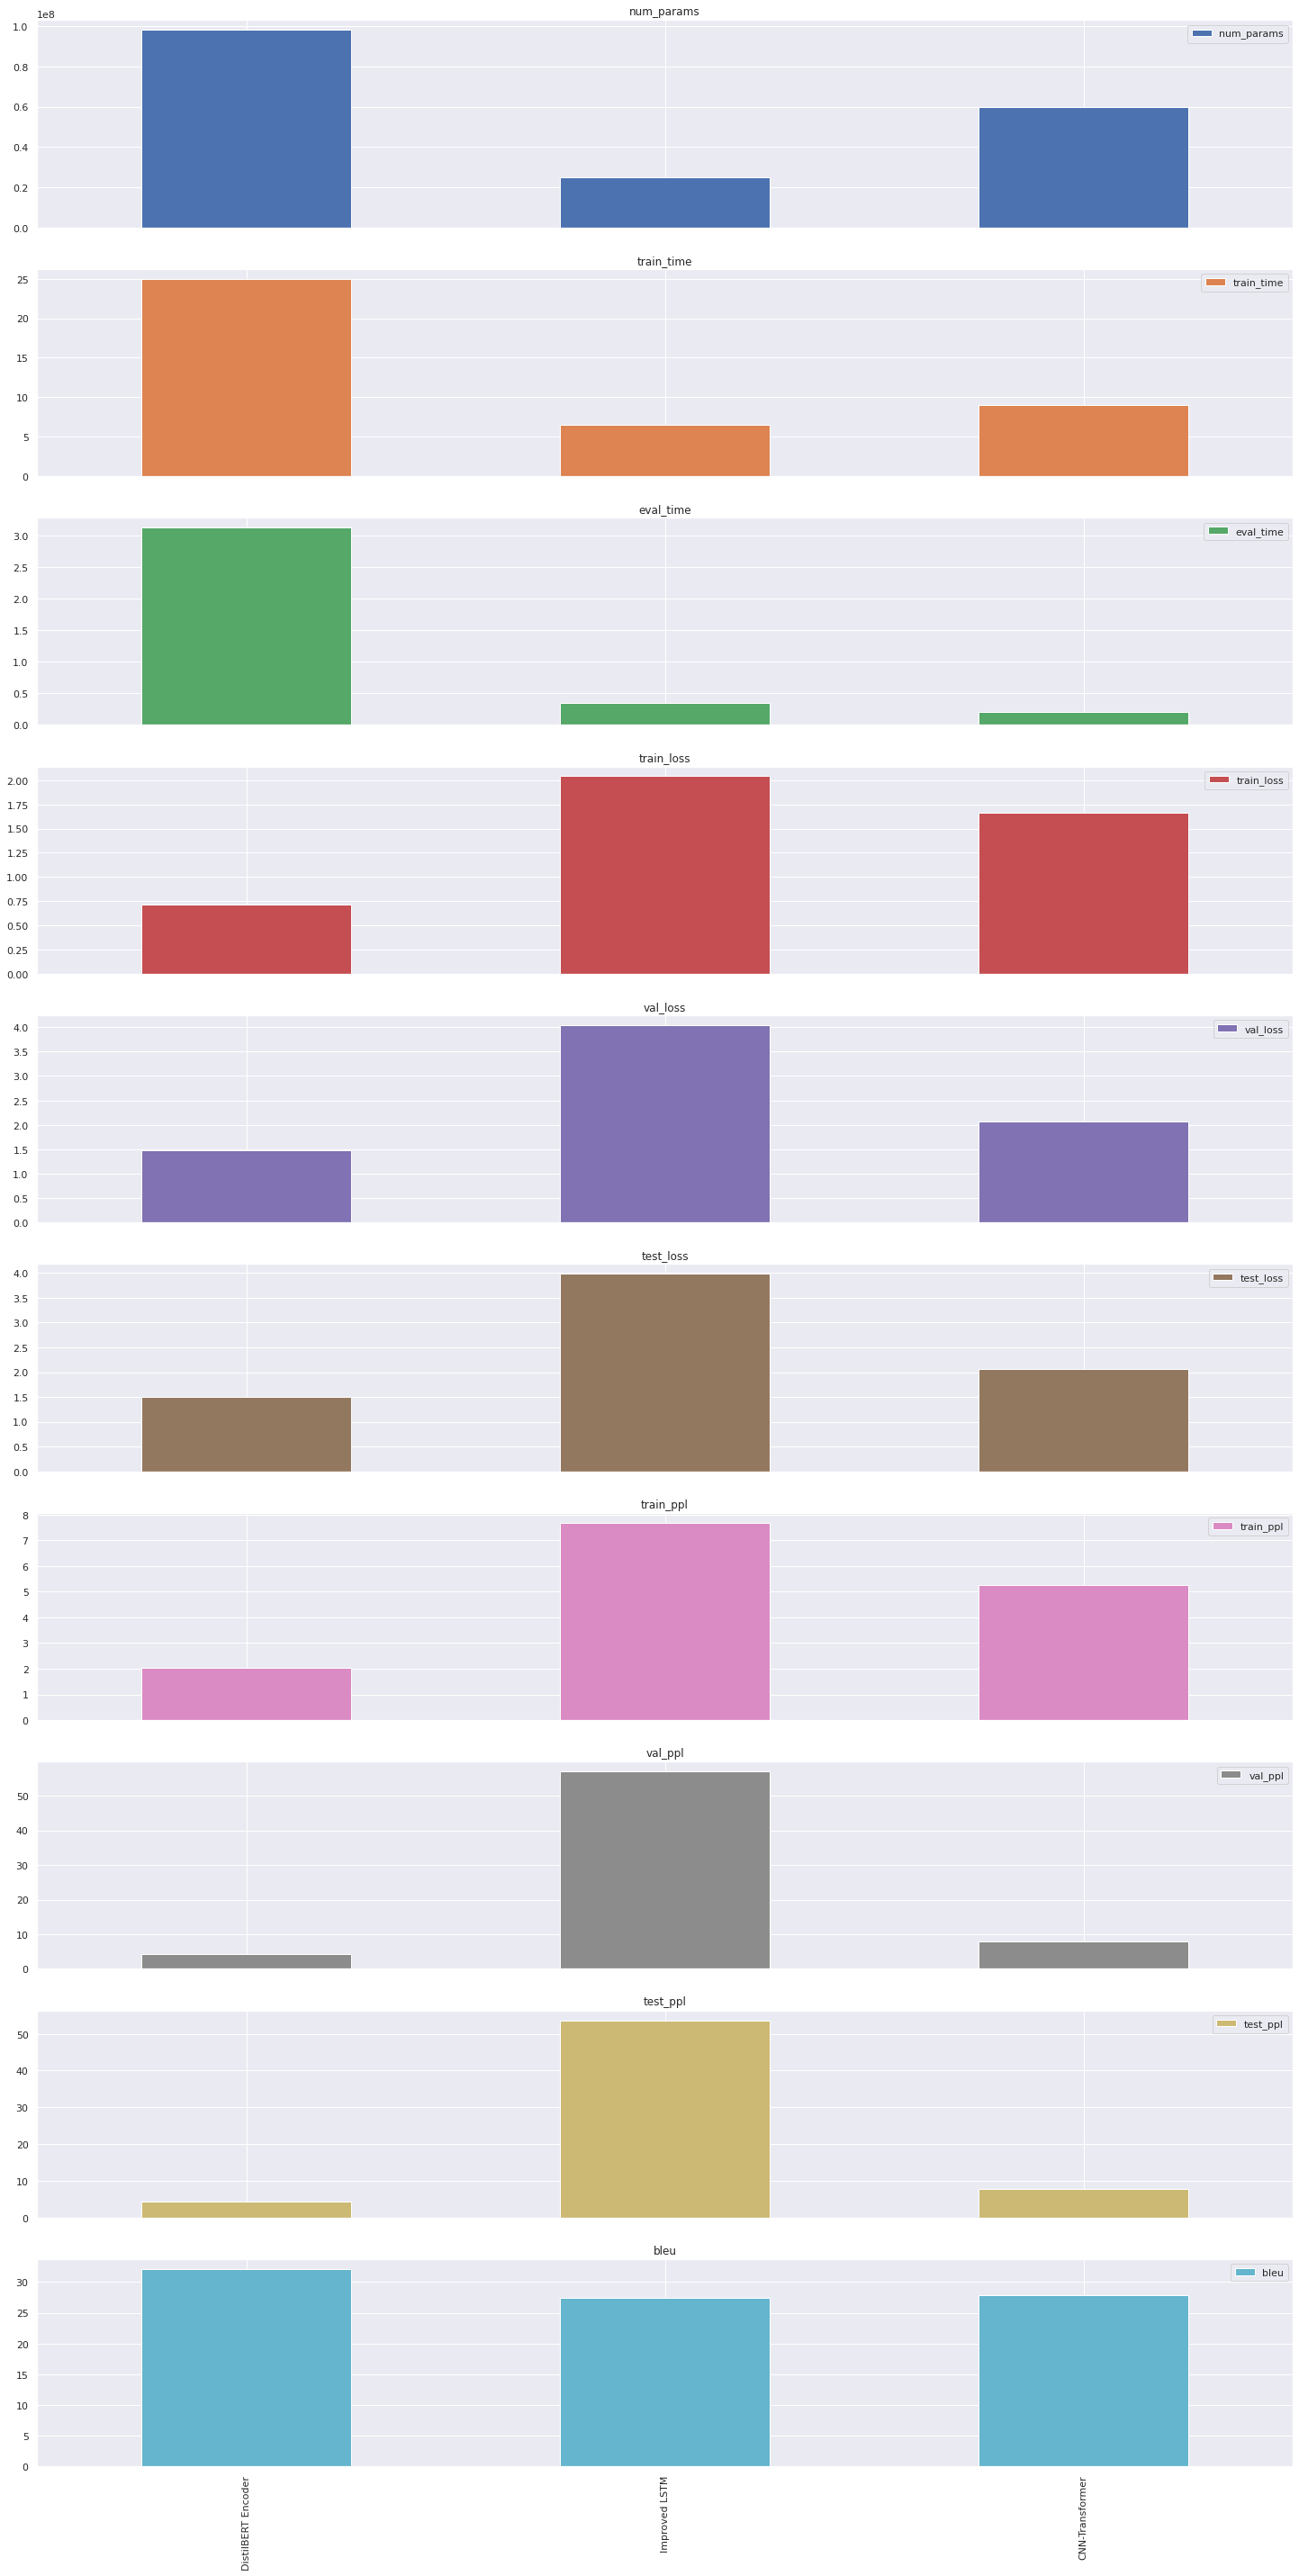

In [ ]:
ax = results.plot.bar(figsize=(25, 50), subplots=True)

Проанализируем полученные во время обучения графики лоссов для всех трех моделей.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_prefix = '/content/drive/MyDrive/Colab Notebooks/girafe-ai assignments/EN-RU models'
history_path_BERT = os.path.join(path_prefix, 'Pretrained-BERT-enc_history-2-3.json')
history_path_LSTM = os.path.join(path_prefix, 'Custom-RNN_history.json')
history_path_CNN = os.path.join(path_prefix, 'CNN-Transformer_history.json')

histories = []
for path in [history_path_BERT, history_path_LSTM, history_path_CNN]:
    with open(path, 'r') as history_file:
        histories.append(json.load(history_file))

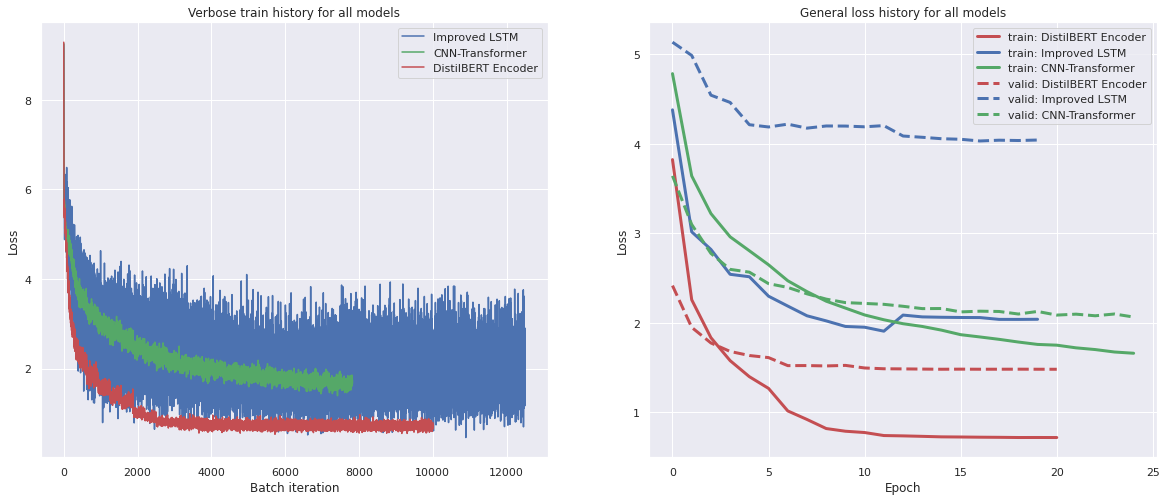

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

ax[0].plot(histories[1]["verbose_train_history"], label="Improved LSTM", color='b')
ax[0].plot(histories[2]["verbose_train_history"], label="CNN-Transformer", color='g')
ax[0].plot(histories[0]["verbose_train_history"], label="DistilBERT Encoder", color='r')
ax[0].set_xlabel('Batch iteration')
ax[0].set_ylabel('Loss')
ax[0].set_title('Verbose train history for all models')
ax[0].legend()

linestyles = ['solid', '--']
modes = ['train', 'valid']
names = ["DistilBERT Encoder", "Improved LSTM", "CNN-Transformer"]
colors = ['r', 'b', 'g']
for i in range(2):
    for j in range(3):
        ax[1].plot(histories[j][modes[i] + '_history'],
                   label=modes[i] + ": " + names[j],
                   color=colors[j],
                   linewidth=3,
                   linestyle=linestyles[i])

ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('General loss history for all models')
ax[1].legend()

plt.show()

LSTM обучалась крайне нестабильно, о чем говорит ширина синей кривой на левом графике. На некоторых примерах эта сеть способна показывать качество большее, чем все остальные модели, но на большинстве, наоборот, лосс заметно больше. DistilBERT Encoder и LSTM быстро вышли на плато, а CNN к моменту остановки еще этого не сделала и в перспективе могла бы достичь сравнимого с первой моделью лосса.

В случае DistilBERT быстрый выход на плато связан с использованием предобученного энкодера. Мы лишь немного поменяли модель под нашу задачу, что можно осуществить быстро. LSTM просто за первые несколько эпох достигла своего предела, так как модель является относительно простой. CNN обучалась с нуля, поэтому ей требуется больше времени, по сравнению с DistilBERT, но способностей у этой модели больше, чем у LSTM. На плавный спад лосса CNN также оказывает позитивное влияние обучение с хорошо подобранным начальным значением learning_rate.

Лоссы CNN на валидации и трейне отличаются гораздо меньше, чем у других моделей, что может говорить о хороших способностях к генерализации. Все валидационные лоссы выходят на плато гораздо быстре, чем на трейне. 

### Общие выводы

**Краткое описание подходов и сравнение моделей, их плюсы и минусы.**

- Первым вариантом был трансформер с предобученным энкодером. Предполагалось, что модель сразу будет способна дать хороший BLEU при относительно небольших усилиях по ее внедрению в код. Так и получилось, ведь предобученные модели уже достаточно хорошо умеют извлекать признаки и их надо лишь немного доработать под решаемую задачу. Плюсами подхода являются простота и эффективность реализации, минусом же — долгое время обучения и инференса, обусловленное большим количеством параметров модели.

- Второй подход с доработкой LSTM преследовал цель узнать, как много можно получить от простейшей модели, добавив в нее новые элементы, а также несколько улучшив препроцессинг и процедуру обучения. Оказалось, что этот комплекс мер позволяет увеличить BLEU практически в 2 раза. Одновременно с этим модель, в некотором смысле, даже стала проще, так как в исходном варианте было 2 слоя, а в конечном только один. При этом модель не стала "тяжелой", время на обучение у нее самое маленькое, а инференс значительно меньше, чем у первой модели и практически такой же, как и у третьей. В качестве плюсов этого подхода можно назвать быстроту обучения и работы, а также простоту реализации. Этот подход, пожалуй, был несколько сложнее, чем вариант с предобученным BERT'ом, однако ничего экзотического в точно нем не применялось. Минусом же можно считать нестабильность результатов, о чем красноречиво говорит график лосса для этой модели на трейне.

- Третий подход можно назвать самым экспериментальным из всех. Идеей было объединить в единое целое несколько разных подходов, не вошедших в предыдущие две модели, и посмотреть, что из этого выйдет. Вышло неплохо. Более того, обучение было остановлено на 25 эпохе намеренно, чтобы можно было сравнить с двумя другими моделями, однако на графиках лосса видно, что обучение еще можно было продолжать, что привело бы к некоторому улучшению качества, пусть и не кардинальному. Сам подход потребовал больше всего усилий по реализации, относительно двух других, потому что в нем наибольшее количество новых элементов, если сравнивать с базовым решением. Плюсами можно назвать самое маленькое время инференса, а также достаточно хорошие результаты, особенно учитывая возможность их улучшения. Минусом же является относительная сложность подхода, однако она закладывалась в него на старте.

Таким образом, в работе были реализованы*:
- DistilBERT fine-tunning (1)
- Механизм self-attention (1, 3)
- Использование [spacy-ru](https://github.com/buriy/spacy-ru) для улучшения препроцессинга (2)
- Позиционные эмбеддинги (1, 2, 3)
- Механизм attention (2)
- Маскирование токенов (1, 2, 3) и pack-padded-sequences средствами PyTorch (2)
- Различные способы инициализации весов модели перед обучением (xavier uniform/normal, kaiming normal) (1, 2, 3)
- Стратегии изменения learning rate: ReduceLROnPlateau (1, 2) и CosineAnnealingLR (3)
- Динамическое изменение teacher forcing ratio во время обучения LSTM-декодера (2)
- CNN-энкодер (3), в котором дополнительно применены:
    - Inception-блоки (параллельное применение сверток с различным размером ядра к одному и тому же входу)
    - skip-connection'ы
    - BN
- Тестирование подачи в encoder-attention часть трансформера различных представлений source-предложения, основываясь на характере информации, которую они несут (3)
- Поиск оптимального начального значения learning rate (3)
- Применение различных значений learning rate к энкодеру и декодеру во время обучения (3)

**Цифрами обозначены подходы, в которых применялся соответствующий пункт.*

Достигнутое качество: 32.12 BLEU.